In [ ]:
# TEXT-TO-IMAGE PIPELINE (GAN + TEXT EMBEDDINGS)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T

In [ ]:
from torchvision.utils import make_grid
from transformers import CLIPTokenizer, CLIPTextModel
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import re, os


In [ ]:
#TEXT PREPROCESSOR
class TextPreprocessor:
  def __init__(self, lowercase= True, remove_punct=True):
    self.lowercase = lowercase
    self.remove_punct = remove_punct

  def clean(self, text: str) -> str:
      text = text.strip()
      if self.lowercase:
          text = text.lower()
      if self.remove_punct:
          text = re.sub(r"[^\w\s]", "", text)
      return text

In [ ]:
#TEXT EMBEDDER
class TextEmbedder:
    """Uses CLIP text encoder to produce semantic embeddings."""
    def __init__(self, model_name="openai/clip-vit-base-patch32", device="auto"):
        self.device = torch.device("cuda" if torch.cuda.is_available() and device != "cpu" else "cpu")
        self.tokenizer = CLIPTokenizer.from_pretrained(model_name)
        self.text_encoder = CLIPTextModel.from_pretrained(model_name).to(self.device)
        self.text_encoder.eval()
    @torch.no_grad()
    def encode(self, text: str) -> torch.Tensor:
      inputs = self.tokenizer(text, return_tensors="pt", padding=True, truncation=True)
      outputs = self.text_encoder(**{k: v.to(self.device) for k, v in inputs.items()})
      return outputs.last_hidden_state.mean(dim=1)  # sentence embedding

In [ ]:
#CONDITIONAL GAN
class Generator(nn.Module):
    """A simple conditional generator using embeddings."""
    def __init__(self, embedding_dim=512, noise_dim=100, img_size=64):
        super().__init__()
        self.input_dim = embedding_dim + noise_dim
        self.net = nn.Sequential(
            nn.Linear(self.input_dim, 256 * 8 * 8),
            nn.BatchNorm1d(256 * 8 * 8),
            nn.ReLU(True),
            nn.Unflatten(1, (256, 8, 8)),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 3, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z, embedding):
        x = torch.cat((z, embedding), dim=1)
        return self.net(x)

In [ ]:

class Discriminator(nn.Module):
    """Conditional discriminator."""
    def __init__(self, embedding_dim=512, img_size=64):
        super().__init__()
        self.img_encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, stride=2, padding=1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2),
            nn.Flatten()
        )
        self.fc = nn.Linear(256 * 8 * 8 + embedding_dim, 1)

    def forward(self, img, embedding):
        img_feat = self.img_encoder(img)
        x = torch.cat((img_feat, embedding), dim=1)
        return torch.sigmoid(self.fc(x))

In [ ]:
#TEXT TO IMAGE PIPELINE
class TextToImagePipeline:
    """Combines text preprocessing, embedding, and GAN generation."""
    def __init__(self, device="auto"):
        self.device = torch.device("cuda" if torch.cuda.is_available() and device != "cpu" else "cpu")
        self.preprocessor = TextPreprocessor()
        self.embedder = TextEmbedder(device=str(self.device))
        self.generator = Generator().to(self.device)
        self.generator.eval()

    def generate(self, text: str, seed: int = None, noise_dim: int = 100) -> Image.Image:
        torch.manual_seed(seed or np.random.randint(0, 999999))
        cleaned = self.preprocessor.clean(text)
        embedding = self.embedder.encode(cleaned)
        noise = torch.randn(1, noise_dim, device=self.device)
        fake_img = self.generator(noise, embedding)
        return self._to_image(fake_img)

    def _to_image(self, tensor):
        img = (tensor.squeeze(0).detach().cpu() + 1) / 2  # scale to [0,1]
        img = T.ToPILImage()(img)
        return img

Generating image for: 'Rose'


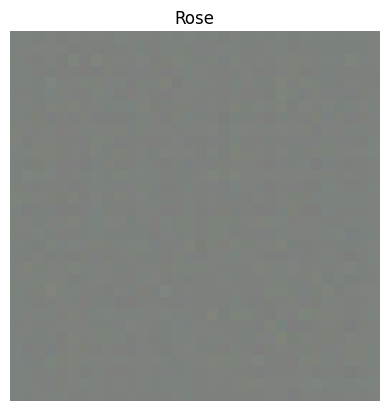

In [ ]:
#SIMULATION
if __name__ == "__main__":
    pipe = TextToImagePipeline()

    prompt = "Rose"
    print(f"Generating image for: '{prompt}'")

    img = pipe.generate(prompt, seed=42)
    img.show()

    # For display in a notebook:
    plt.imshow(img)
    plt.axis("off")
    plt.title(prompt)
    plt.show()